In [1]:
import os
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def to_month_dt(s: str):
    try:
        return pd.to_datetime(s + "-01", format="%Y-%m-%d")
    except Exception:
        try:
            return pd.to_datetime(s)
        except Exception:
            return pd.NaT

def map_origin_category(origin: str) -> str:
    if not isinstance(origin, str):
        return "Other"
    o = origin.lower()
    # Heuristiken
    if any(k in o for k in ["private", "rsa", "ecdsa", "ed25519", "ssh", "private_key", "pgp", "gpg", "pem", "pkey"]):
        return "Private Keys"
    if any(k in o for k in ["token", "oauth", "bearer", "github", "gitlab", "gh_token"]):
        return "Tokens"
    if any(k in o for k in ["aws", "s3", "access_key", "secret_key", "gcp", "google", "azure", "cloud", "firebase", "twilio", "stripe", "slack", "sendgrid"]):
        return "Cloud/API Keys"
    if any(k in o for k in ["password", "passwd", "cred", "credential", "db_", "mysql", "postgres", "mongo"]):
        return "Credentials"
    return "Other"

def style():
    # kein Grid
    sns.set_theme(style="white", context="talk")
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titleweight": "bold",
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "legend.frameon": False,
        "savefig.dpi": 200,
        "axes.grid": False
    })

In [18]:
def plot_rq1(repos_csv: str, outdir: str):
    df = pd.read_csv(repos_csv)
    if df.empty:
        return
    df["month"] = df["month_key"].apply(to_month_dt)
    df = df.dropna(subset=["month"]).sort_values("month")
    # Zeitraum 2016–2025
    df = df[(df["month"] >= pd.Timestamp("2016-01-01")) & (df["month"] < pd.Timestamp("2026-01-01"))]

    # kumulierte gewichtete Summen
    df["cum_total_w"] = df["total_repos_weighted"].fillna(0).cumsum()
    df["cum_secret_w"] = df["repos_with_secret_weighted"].fillna(0).cumsum()

    # Anteil (monatlich, gewichtet) für Hintergrund
    with np.errstate(divide="ignore", invalid="ignore"):
        share = df["repos_with_secret_weighted"] / df["total_repos_weighted"]
    share = share.replace([np.inf, -np.inf], np.nan).fillna(0.0).astype(float)
    df["share_w"] = share

    fig, ax_left = plt.subplots()
    ax_left.grid(False)

    # Hintergrundfläche: Anteil (auf linke Skala skaliert)
    scale = float(df["cum_total_w"].max()) if df["cum_total_w"].max() > 0 else 1.0
    ax_left.fill_between(df["month"], 0, df["share_w"] * scale, color="lightgray", alpha=0.5, linewidth=0, zorder=0)
    print(df[df["share_w"]>0.4])
    print(df.iloc[-1])
    # Linke Achse: kumulativ total (gewichtet)
    line_total, = ax_left.plot(df["month"], df["cum_total_w"], color="#1f77b4", label="Total (kumuliert, gewichtet)")

    # Rechte Achse: kumulativ mit Secret (gewichtet)
    ax_right = ax_left.twinx()
    ax_right.grid(False)
    line_secret, = ax_right.plot(df["month"], df["cum_secret_w"], color="#d62728", label="Mit Secret (kumuliert, gewichtet)")

    # Ereignislinien (optional)
    #ax_left.axvline(pd.Timestamp("2016-01-01"), color="gray", linestyle="--", linewidth=1)
    #ax_left.axvline(pd.Timestamp("2023-05-01"), color="gray", linestyle="--", linewidth=1)

    ax_left.set_xlabel("Monat")
    ax_left.set_ylabel("Kumulierte gewichtete Repositories (Total)")
    ax_right.set_ylabel("Kumulierte gewichtete Repositories (mit Secret)")

    # kombinierte Legende
    handles = [line_total, line_secret]
    labels = [h.get_label() for h in handles]
    ax_left.legend(handles, labels, loc="upper left")

    ensure_dir(outdir)
    fig.tight_layout()
    fig.savefig(os.path.join(outdir, "RQ1_repo_share_with_secrets_timeseries.eps"), bbox_inches="tight")
    fig.savefig(os.path.join(outdir, "RQ1_repo_share_with_secrets_timeseries.png"), bbox_inches="tight")
    plt.show(fig)
    plt.close(fig)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


    month_key  total_repos  total_repos_weighted  repos_with_secret  \
3     2016-09         2245           1994.664978               1632   
51    2020-09         7179          10860.410394               2658   
88    2023-10        11957           9713.951984               6602   
107   2025-05        18568          16799.082781              11599   

     repos_with_secret_weighted      month    cum_total_w  cum_secret_w  \
3                   1534.003597 2016-09-01    4083.412641   1871.680652   
51                  5375.225750 2020-09-01  176494.187162  27742.964738   
88                  5706.859114 2023-10-01  366351.634604  55289.168603   
107                11537.300643 2025-05-01  507564.105986  81473.728128   

      share_w  
3    0.769053  
51   0.494938  
88   0.587491  
107  0.686782  
month_key                                 2025-08
total_repos                                  4671
total_repos_weighted                  4596.097011
repos_with_secret                     

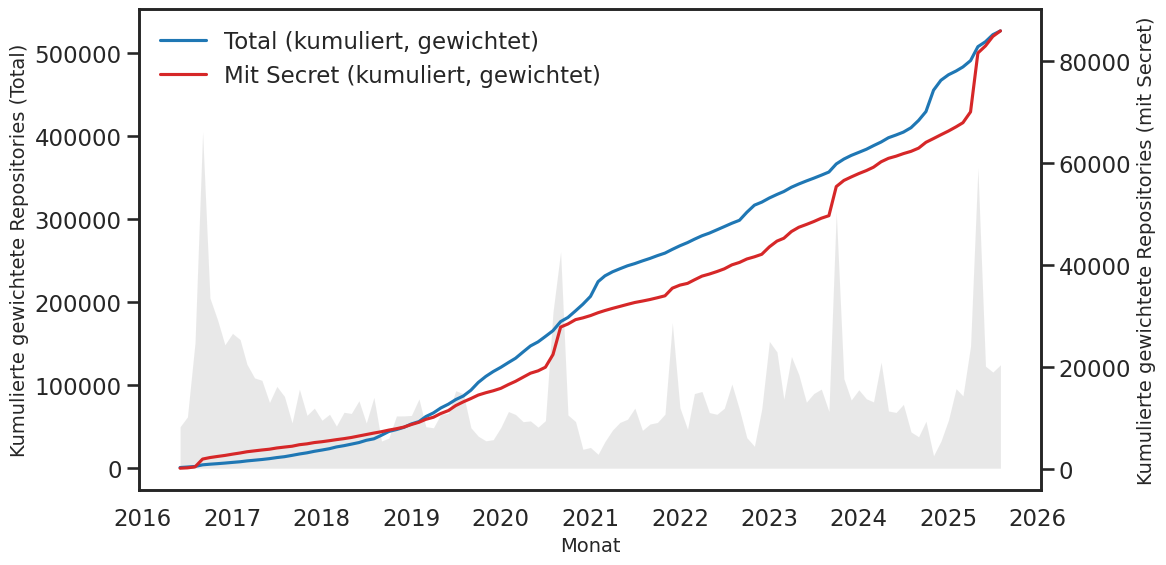

In [19]:
outdir = "plots"
empiric_dir = "../empiric_outputs_filtered/"
style()
ensure_dir(outdir)

# RQ1
plot_rq1(
    repos_csv=os.path.join(empiric_dir, "repos_with_secret_per_month.csv"),
    outdir=outdir
)

In [10]:
def plot_rq2(top20_csv: str, outdir: str):
    # Wenn komplette Häufigkeiten vorhanden, nutze diese
    all_csv = os.path.join(os.path.dirname(top20_csv), "secret_origin_frequency.csv")
    src_csv = all_csv if os.path.exists(all_csv) else top20_csv
    df = pd.read_csv(src_csv)
    if df.empty:
        return

    # Spaltennamen normalisieren
    if "n" not in df.columns and "count" in df.columns:
        df = df.rename(columns={"count": "n"})
    if "origin" not in df.columns:
        for c in df.columns:
            if c.lower() in ("origin", "secret_origin"):
                df = df.rename(columns={c: "origin"})
                break
    df = df[["origin", "n"]].copy()
    df = df.sort_values("n", ascending=False)

    # Barplot (horizontale Balken), exakte Werte an Balken
    fig, ax = plt.subplots(figsize=(12, max(6, 0.35 * len(df))))
    ax.grid(False)
    sns.barplot(data=df, y="origin", x="n", ax=ax, color="#1f77b4")
    ax.set_xlabel("Anzahl Vorkommen")
    ax.set_ylabel("Arten")
    max_val = df["n"].max()
    ax.set_xlim(0, max_val * 1.2)
    for p, val in zip(ax.patches, df["n"].tolist()):
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.text(width, y, f" {int(val)}", va="center", ha="left", fontsize=11, color="black")

    fig.tight_layout()
    ensure_dir(outdir)
    fig.savefig(os.path.join(outdir, "RQ2_secret_origins_bar.eps"), bbox_inches="tight")
    fig.savefig(os.path.join(outdir, "RQ2_secret_origins_bar.png"), bbox_inches="tight")
    plt.show()
    plt.close(fig)




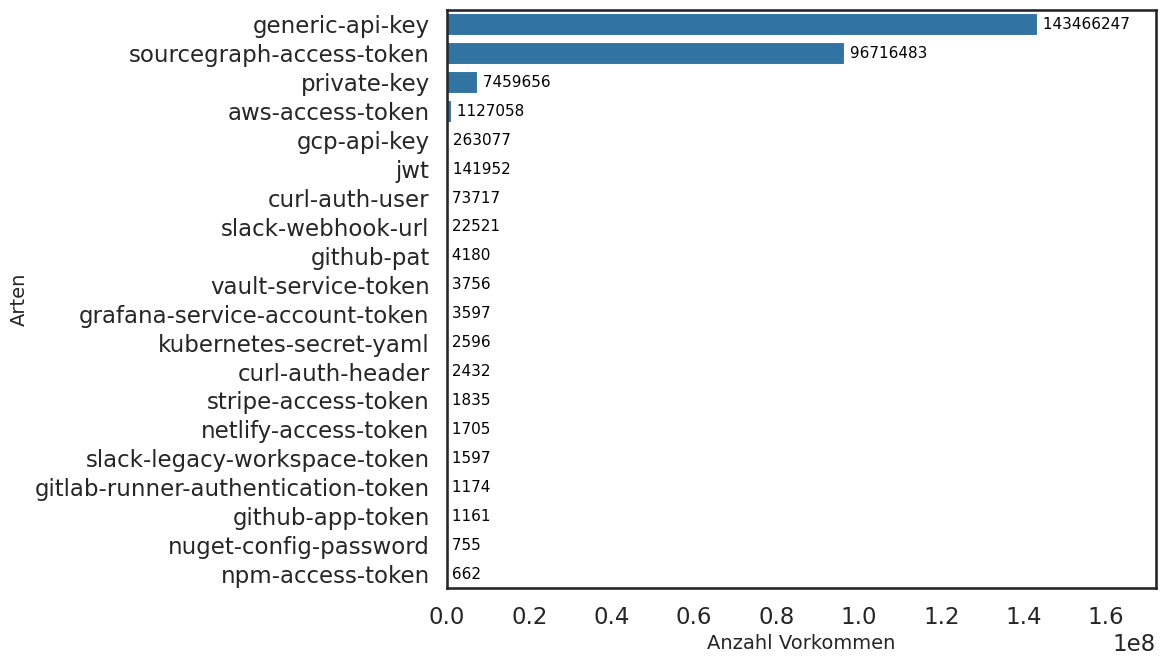

In [11]:
plot_rq2(
        top20_csv=os.path.join(empiric_dir, "top20_secret_origin.csv"),
        outdir=outdir
    )

In [20]:
def plot_rq3(dist_csv: str, outdir: str):
    df = pd.read_csv(dist_csv)
    if df.empty:
        return
    df = df.sort_values("repo_count")

    # CCDF
    df = df.sort_values("repo_count")
    df["cum_ge"] = df["secret_count"][::-1].cumsum()[::-1]
    print(df.iloc[-1])
    fig, ax = plt.subplots()
    ax.grid(False)
    ax.plot(df["repo_count"], df["cum_ge"] / df["secret_count"].sum(), marker="o")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Repos pro Secret (x)")
    ax.set_ylabel("P(Repos≥x)")
    fig.tight_layout()
    ensure_dir(outdir)
    fig.savefig(os.path.join(outdir, "RQ3_repo_count_per_secret_ccdf.eps"), bbox_inches="tight")
    fig.savefig(os.path.join(outdir, "RQ3_repo_count_per_secret_ccdf.png"), bbox_inches="tight")
    plt.show()
    plt.close(fig)

repo_count      14316
secret_count        1
cum_ge              1
Name: 456, dtype: int64


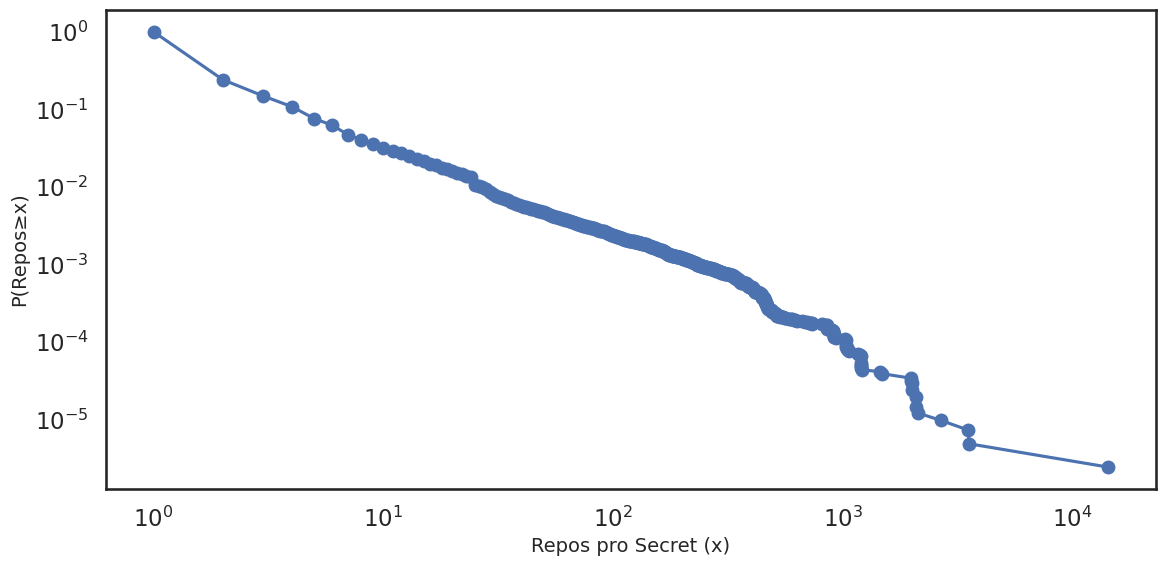

In [21]:
 plot_rq3(
        dist_csv=os.path.join(empiric_dir, "secret_repo_counts_distribution.csv"),
        outdir=outdir
    )

In [44]:
def plot_rq6(counts_csv: str, outdir: str):
    if not os.path.exists(counts_csv):
        print("Wrong Path")
        return
    df = pd.read_csv(counts_csv)
    if df.empty:
        print("DF empty")
        return
    print(df.head())
    # sichere Typen und Spalten prüfen
    if "repo_count" not in df.columns or "layer_count" not in df.columns:
        print("Wrong Columns")
        return
    df["repo_count"] = pd.to_numeric(df["repo_count"], errors="coerce").fillna(0).astype(int)
    df["layer_count"] = pd.to_numeric(df["layer_count"], errors="coerce").fillna(0).astype(int)
    min_max = int(min(df["repo_count"].max(), df["layer_count"].max()))
    if min_max < 1:
        print("Smaller than 1")
        return
    print(df.head())
    x_vals = np.arange(1, min_max + 1, dtype=int)

    # CCDF: Anteil Secrets mit repo_count >= x UND layer_count >= x
    n = len(df)
    y_vals = np.array([(((df["repo_count"] >= x) & (df["layer_count"] >= x)).sum()) / n for x in x_vals], dtype=float)

    fig, ax = plt.subplots()
    ax.grid(False)
    ax.plot(x_vals, y_vals, marker="o", linestyle="-", color="#1f77b4")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("x (Anzahl Repos und Layer)")
    ax.set_ylabel("P(>= x Repos und >= x Layer)")
    fig.tight_layout()
    ensure_dir(outdir)
    fig.savefig(os.path.join(outdir, "RQ3_repo_layer_joint_ccdf.eps"), bbox_inches="tight")
    fig.savefig(os.path.join(outdir, "RQ3_repo_layer_joint_ccdf.png"), bbox_inches="tight")
    plt.show()
    plt.close(fig)

      fragment_hash  repo_count  layer_count  weighted_layer_count
0  00001876b3aa2042           1            1              0.301167
1  0000265e6d8fb505          52           33             97.782277
2  00003297b68085f7           1            1              0.301167
3  0000aa721b434447           3            3              0.903502
4  0000c227f726abca           1            1              0.301167
      fragment_hash  repo_count  layer_count  weighted_layer_count
0  00001876b3aa2042           1            1              0.301167
1  0000265e6d8fb505          52           33             97.782277
2  00003297b68085f7           1            1              0.301167
3  0000aa721b434447           3            3              0.903502
4  0000c227f726abca           1            1              0.301167


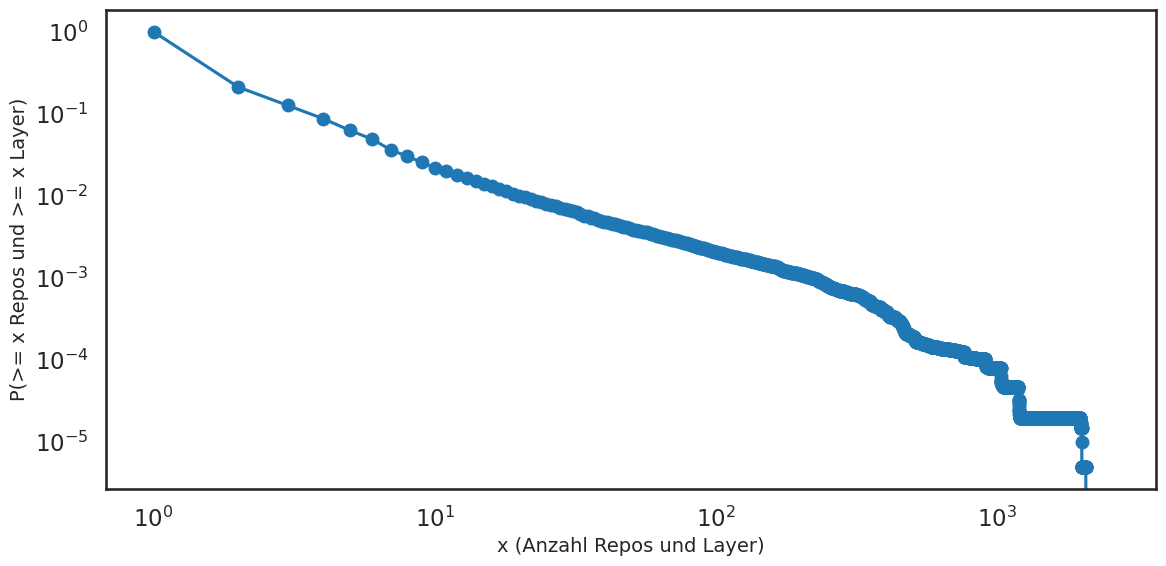

In [46]:
 plot_rq6(
        counts_csv=os.path.join(empiric_dir, "secret_repo_layer_counts_weighted.csv"),
        outdir=outdir
    )

In [52]:
def plot_rq4(metrics_csv: str, contingency_dir: str, outdir: str):
    dfm = pd.read_csv(metrics_csv)
    if dfm.empty:
        return
        
    dfm["abs_value"] = dfm["value"].abs()
    dfm = dfm.sort_values("abs_value", ascending=False)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(False)
    sns.barplot(data=dfm, x="variable", y="abs_value", hue="type", ax=ax)
    ax.set_xlabel("Variable")
    ax.set_ylabel("Stärke (|Korrelation| bzw. Cramér’s V)")
    for tick in ax.get_xticklabels():
        tick.set_rotation(20)
    ax.legend(title="")
    fig.tight_layout()
    ensure_dir(outdir)
    fig.savefig(os.path.join(outdir, "RQ4_association_strengths.eps"), bbox_inches="tight")
    fig.savefig(os.path.join(outdir, "RQ4_association_strengths.png"), bbox_inches="tight")
    plt.show()
    plt.close(fig)
    for col in ["status_cat", "is_official_cat", "is_automated_cat"]:
        path = os.path.join(contingency_dir, f"contingency_{col}.csv")
        if not os.path.exists(path):
            continue
        dfc = pd.read_csv(path)
        if dfc.empty:
            continue
        dfc = dfc.set_index(col)
        fig, ax = plt.subplots(figsize=(8, 4 + 0.4 * len(dfc)))
        ax.grid(False)
        sns.heatmap(dfc, annot=True, fmt=".0f", cmap="Blues", ax=ax)
        fig.tight_layout()
        #fig.savefig(os.path.join(outdir, f"RQ4_contingency_{col}.eps"), bbox_inches="tight")
        #fig.savefig(os.path.join(outdir, f"RQ4_contingency_{col}.png"), bbox_inches="tight")
        plt.show()
        plt.close(fig)

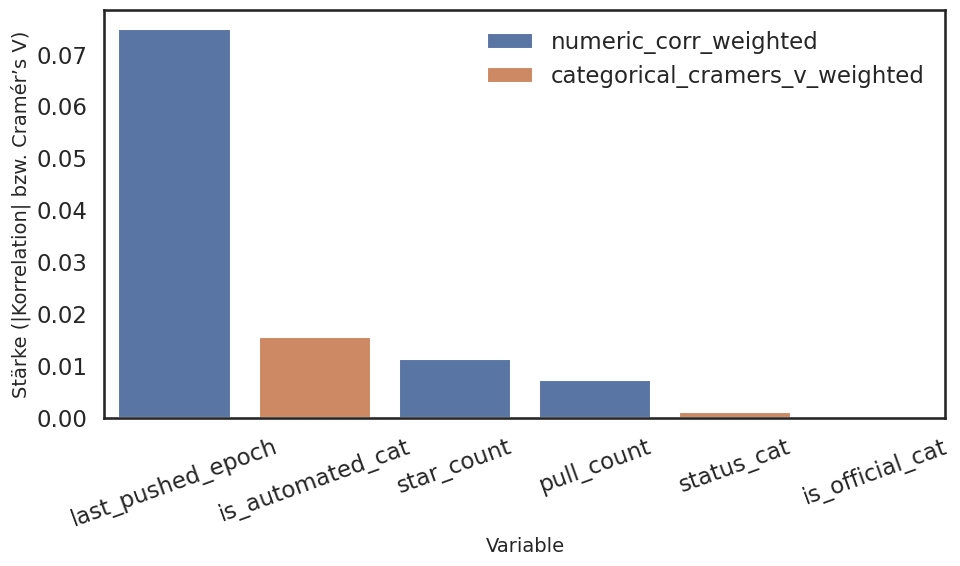

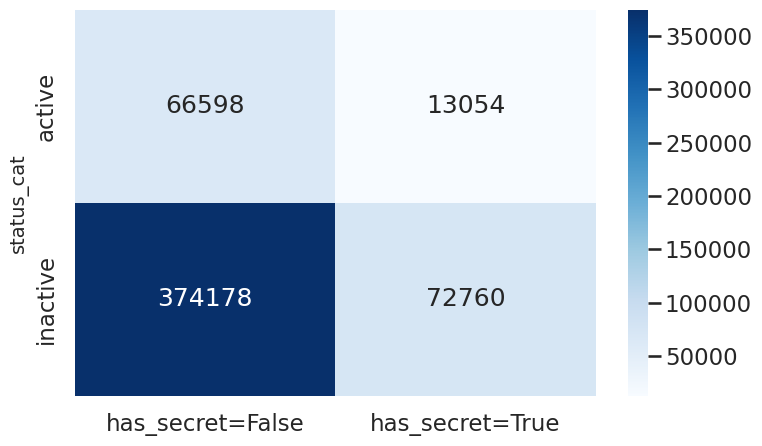

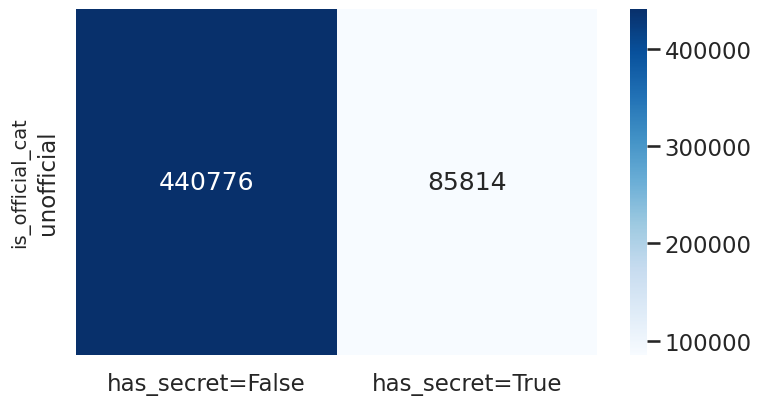

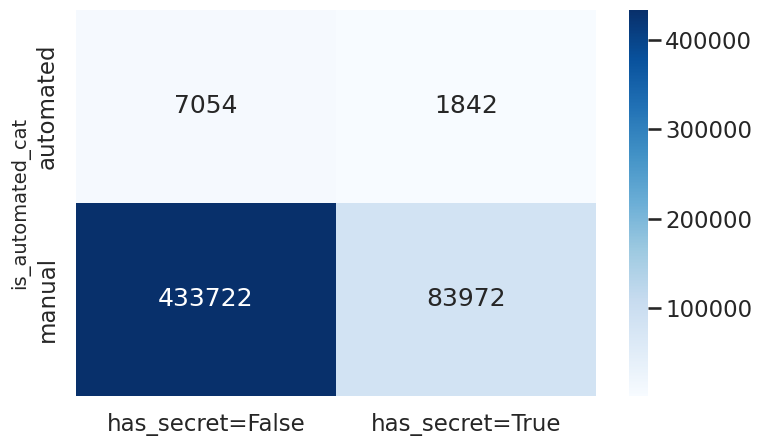

In [53]:
plot_rq4(
        metrics_csv=os.path.join(empiric_dir, "metadata_association_metrics.csv"),
        contingency_dir=empiric_dir,
        outdir=outdir
    )

In [54]:
def plot_rq5(top20_csv: str, outdir: str):
    # Wenn komplette Häufigkeiten vorhanden, nutze diese
    all_csv = os.path.join(os.path.dirname(top20_csv), "secrets_filetype_frequency.csv")
    src_csv = all_csv if os.path.exists(all_csv) else top20_csv
    df = pd.read_csv(src_csv)
    if df.empty:
        return

    # Spaltennamen normalisieren
    if "n" not in df.columns and "count" in df.columns:
        df = df.rename(columns={"count": "n"})
    if "file_type" not in df.columns:
        for c in df.columns:
            if c.lower() in ("file_type", "secrets_file_type"):
                df = df.rename(columns={c: "file_type"})
                break
    df = df[["file_type", "n"]].iloc[:19].copy()
    df = df.sort_values("n", ascending=False)

    # Barplot (horizontale Balken), exakte Werte an Balken
    fig, ax = plt.subplots(figsize=(12, max(6, 0.35 * len(df))))
    ax.grid(False)
    sns.barplot(data=df, y="file_type", x="n", ax=ax, color="#1f77b4")
    ax.set_xlabel("Anzahl Vorkommen")
    ax.set_ylabel("Datei Typ")
    max_val = df["n"].max()
    ax.set_xlim(0, max_val * 1.15)
    for p, val in zip(ax.patches, df["n"].tolist()):
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.text(width, y, f" {int(val)}", va="center", ha="left", fontsize=11, color="black")

    fig.tight_layout()
    ensure_dir(outdir)
    fig.savefig(os.path.join(outdir, "RQ2_secret_file_types_bar.eps"), bbox_inches="tight")
    fig.savefig(os.path.join(outdir, "RQ2_secret_file_types_bar.png"), bbox_inches="tight")
    plt.show()
    plt.close(fig)

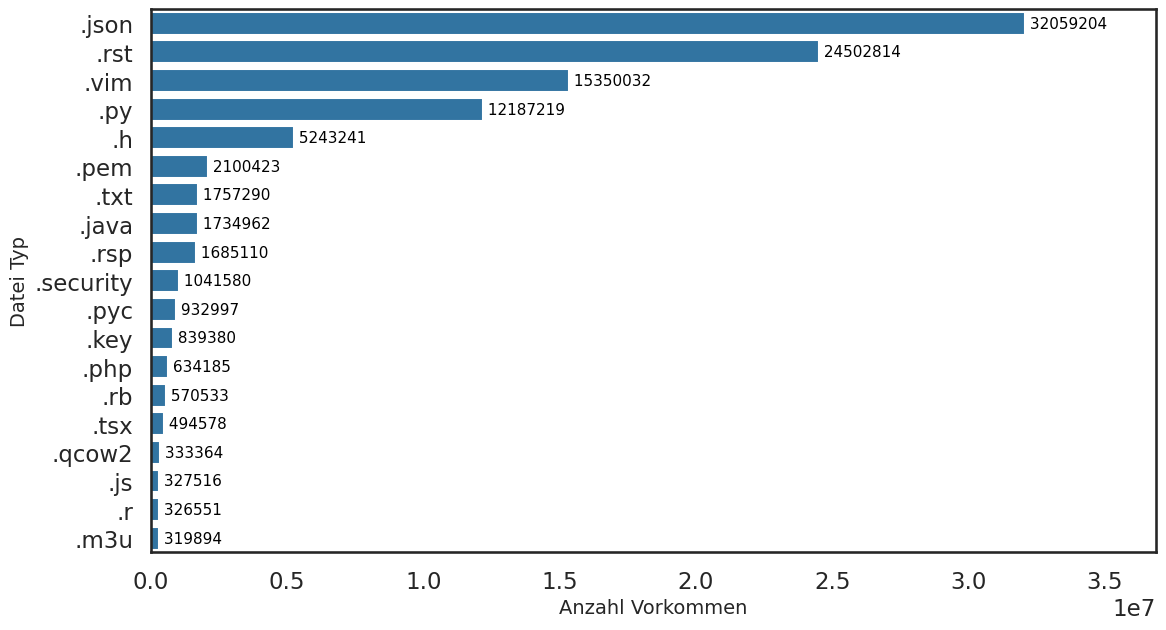

In [55]:
plot_rq5(
        top20_csv=os.path.join(empiric_dir, "secrets_filetype_frequency.csv"),
        outdir=outdir
    )